### Imports, loading features and DB

In [1]:
import sys
sys.path.insert(0, '..')

import operator as op
import pickle


In [2]:
from xgboost import XGBRFClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from metrics.metrics_utils import  get_froc_df_of_many_imgs_features
from mc_candidate_proposal.candidate_utils import balance_candidates
from general_utils.plots import plot_bboxes_over_image
from metrics.metrics import froc_curve, froc_curve_bootstrap
from general_utils.plots import plot_froc, plot_bootstrap_froc
import seaborn as sns
from database.dataset import *

In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [4]:
# used to merge batches of features, ignore

# features_data1 = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/all_data_df_1.f')
# features_data2 = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/all_data_df_2.f')

# fnsdf1 =  pd.read_feather('/home/vzalevskyi/projects/data/features/morph/fns_df_1.f')
# fnsdf2 =  pd.read_feather('/home/vzalevskyi/projects/data/features/morph/fns_df_2.f')

# ignored1 = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/ingnored_df_1.f')
# ignored2 = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/ingnored_df_2.f')

# features_data = pd.concat([features_data1, features_data2]).reset_index().drop(columns=['index'])
# fnsdf = pd.concat([fnsdf1, fnsdf2]).reset_index().drop(columns=['index'])
# ignored = pd.concat([ignored1, ignored2]).reset_index().drop(columns=['index'])

# features_data.to_feather('/home/vzalevskyi/projects/data/features/morph/features_morph.f')
# fnsdf.to_feather('/home/vzalevskyi/projects/data/features/morph/fnsdf_morph.f')
# ignored.to_feather('/home/vzalevskyi/projects/data/features/morph/ignored_morph.f')


features_data = pd.read_feather('/home/vzalevskyi/projects/data/features/hough/features_hough.f')
fnsdf = pd.read_feather('/home/vzalevskyi/projects/data/features/hough/fnsdf_hough.f')
ignored = pd.read_feather('/home/vzalevskyi/projects/data/features/hough/ignored_hough.f')

In [5]:
print('Sensitivity over all mC (max sens value achived in froc without NMS) ',features_data.label.sum() / (features_data.label.sum() + len(fnsdf)))

Sensitivity over all mC (max sens value achived in froc without NMS)  0.8897277965428174


In [6]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_'in x]
wavelet_cols = [x for x in features_data if  x[:6] == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if  'haar' in x]
features_sets = {'fos':fos_cols, 'gabor':gabor_cols, 'wavelet':wavelet_cols,
                 'haar':haar_cols,
                 'all_features':fos_cols+gabor_cols+wavelet_cols+haar_cols}


# need to add SVC but a fast implementation or just wait a lot
classifiers = {'XGBRF': XGBRFClassifier(n_estimators=100, max_depth=6, n_jobs=6),
               'RF': RandomForestClassifier(n_estimators=100, max_depth=6, n_jobs=6),
               'SVC':SVC(C=10, probability=True)}

In [7]:
# adding case_id column for case_wise K-fold CV splits
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

# Cascade Analysis

## Feature Sets/ Models comparison

In [8]:
kfolds = 5
FP2TP_rate = 10
conf_thresholds = np.linspace(0.01, 0.99)


# splitting data into train/validation case-wise
all_case_ids = features_data.case_id.unique()
kfolds_case_splits = np.array_split(all_case_ids, kfolds)

comparison_results = {'train':{'roc_auc':{},
                               'pr_auc':{},
                               'sens_fp_reduction':{}
                               },
                      'valid':{'roc_auc':{},
                               'pr_auc':{},
                               'sens_fp_reduction':{}
                               }
                      }

for feature_set_name, features_set in features_sets.items():

    for clf_name, clf in classifiers.items():
        
        fold_roc_aucs_train = []
        fold_pr_aucs_train = []
        fold_sens_fp_red_train = []
        
        fold_roc_aucs_valid = []
        fold_pr_aucs_valid = []
        fold_sens_fp_red_valid = []
        
        
        # kfold CV
        for valid_case_ids in tqdm(kfolds_case_splits):
            
            # split data into test
            test_split_mask = features_data.case_id.isin(valid_case_ids)
            
            # split into train and take into account cleaned data with no mC in the borders of the patch
            cleaned_features_data = features_data[~test_split_mask]
            
            # and sampling to a predefined 1:FP2TP_rate TP:FP samples
            positive_mask = (cleaned_features_data.label>0)
            positive_train_part = cleaned_features_data[positive_mask]
            negative_train_part = cleaned_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum())
            
            
            train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
            
            test_df = features_data[test_split_mask]
            
            train_y = train_df.label
            test_y = test_df.label
            
            scaler = MinMaxScaler()
            train_X_scaled = scaler.fit_transform(train_df[features_set].values)
            test_X_scaled = scaler.transform(test_df[features_set].values)
            
            clf.fit(train_X_scaled, train_y)

            train_y_predicted = clf.predict_proba(train_X_scaled)[:,1]
            test_y_predicted = clf.predict_proba(test_X_scaled)[:,1]
            
            # save roc_auc
            fold_roc_aucs_train.append(roc_auc_score(train_y, train_y_predicted))
            fold_roc_aucs_valid.append(roc_auc_score(test_y, test_y_predicted))

            # save pr_auc
            pr, rc, _ = precision_recall_curve(train_y, train_y_predicted)
            fold_pr_aucs_train.append(auc(rc, pr))
            pr, rc, _ = precision_recall_curve(test_y, test_y_predicted)
            fold_pr_aucs_valid.append(auc(rc, pr))
            
            # save sens_fp_reduction valid
            sens, fpr = [1], [0]
            for pred_thr in conf_thresholds:
                test_y_pred_binarized = (test_y_predicted>pred_thr).astype(bool)
                TP = (test_y & test_y_pred_binarized).sum()
                FN = (test_y & ~test_y_pred_binarized).sum()
                FP = (~test_y & test_y_pred_binarized).sum()
                max_FP_possible = (~test_y).sum()
                sens.append(TP/(TP + FN))
                fpr.append(1 - FP/max_FP_possible)
            # unifying curves for detectors to have same point of end and begining
            sens.append(0)
            fpr.append(1)
            fold_sens_fp_red_valid.append(auc(sens, fpr))
            
            # save sens_fp_reduction train
            sens, fpr = [1], [0]
            for pred_thr in conf_thresholds:
                test_y_pred_binarized = (train_y_predicted>pred_thr).astype(bool)
                TP = (train_y & test_y_pred_binarized).sum()
                FN = (train_y & ~test_y_pred_binarized).sum()
                FP = (~train_y & test_y_pred_binarized).sum()
                max_FP_possible = (~train_y).sum()
                sens.append(TP/(TP + FN))
                fpr.append(1 - FP/max_FP_possible)
            # unifying curves for detectors to have same point of end and begining
            sens.append(0)
            fpr.append(1)
            fold_sens_fp_red_train.append(auc(sens, fpr))
        
        clf = f'{feature_set_name}_{str(clf_name)}'
        
        comparison_results['train']['roc_auc'][clf] = fold_roc_aucs_train
        comparison_results['train']['pr_auc'][clf] = fold_pr_aucs_train
        comparison_results['train']['sens_fp_reduction'][clf] = fold_sens_fp_red_train
        
        comparison_results['valid']['roc_auc'][clf] = fold_roc_aucs_valid
        comparison_results['valid']['pr_auc'][clf] = fold_pr_aucs_valid
        comparison_results['valid']['sens_fp_reduction'][clf] = fold_sens_fp_red_valid
        


 20%|██        | 1/5 [04:06<16:27, 246.94s/it]


KeyboardInterrupt: 

In [ ]:
with open('hough_comparison_results.pkl', 'wb') as f:
    pickle.dump(comparison_results, f)

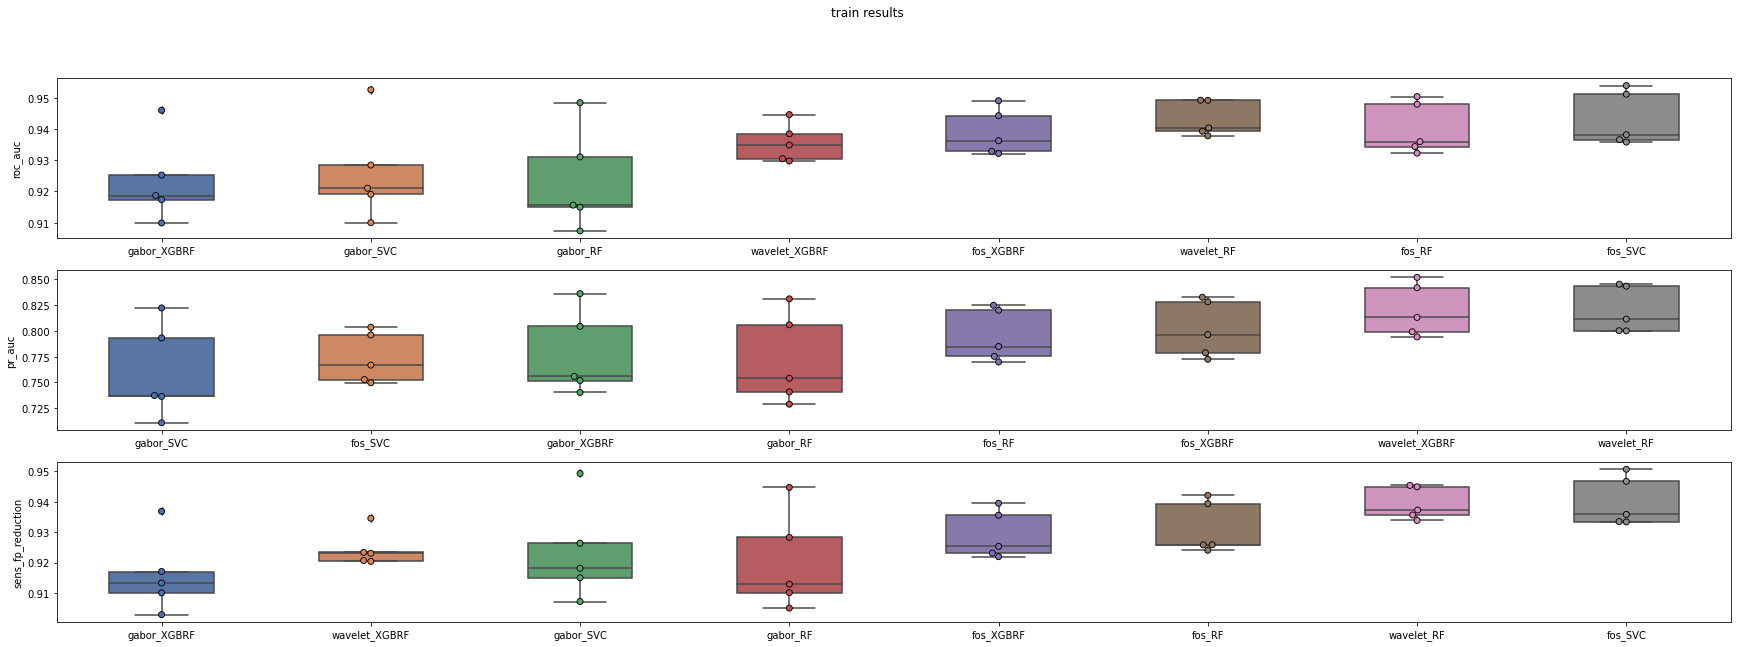

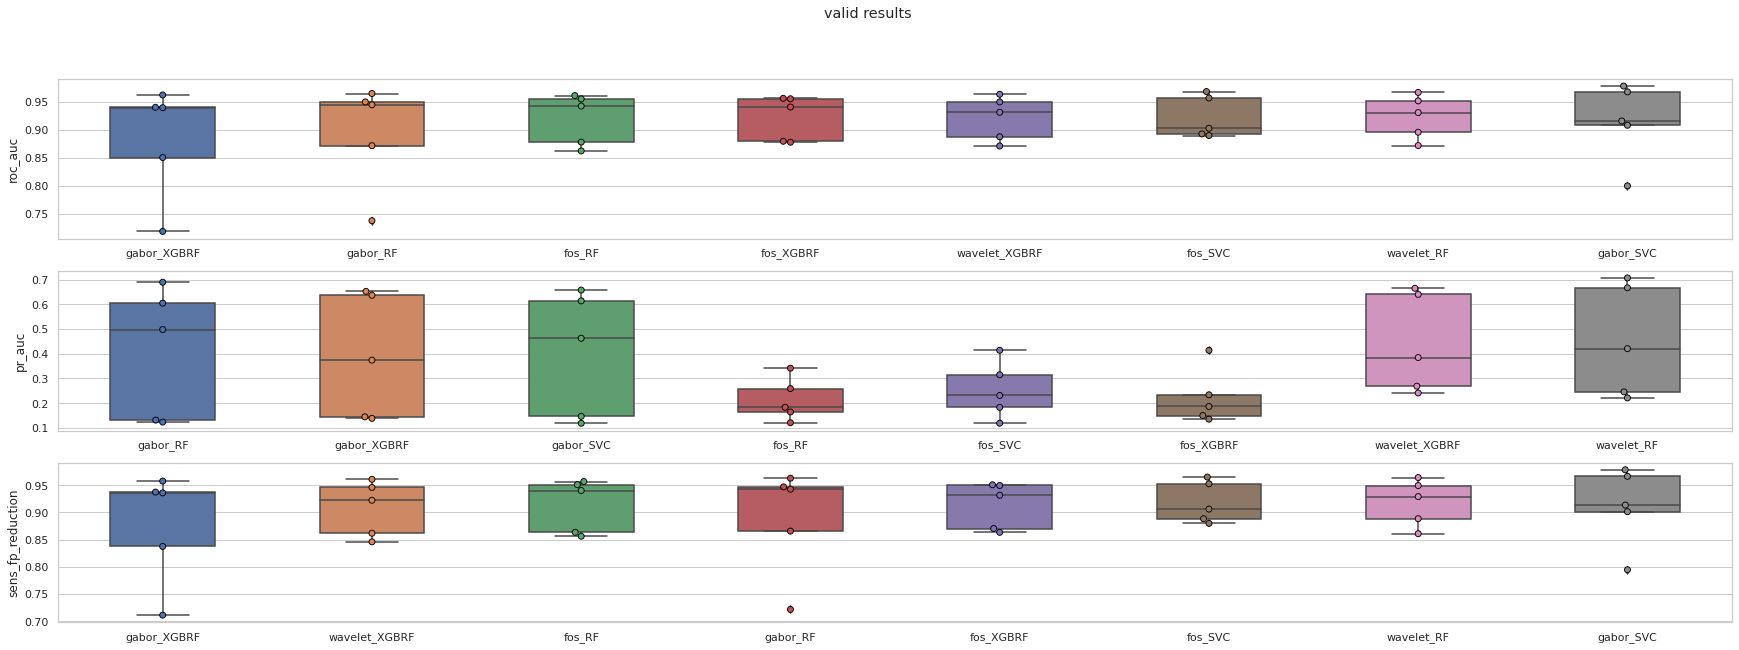

In [9]:

for k in comparison_results.keys():
    fig, axs = plt.subplots(3, 1, figsize=(30, 10))
    fig.suptitle(f'{k} results')
    sns.set(context='notebook', style='whitegrid')
    for metric_name_idx, metric_name in enumerate(comparison_results[k].keys()):
        plot_data= comparison_results[k][metric_name]

        # sort keys and values together
        sorted_keys, sorted_vals = zip(*sorted(plot_data.items(), key=op.itemgetter(1)))



        ax = sns.boxplot(data=sorted_vals, width=.5, ax=axs[metric_name_idx])
        ax.set(ylabel=metric_name)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
        sns.swarmplot(data=sorted_vals, size=6, edgecolor="black", linewidth=.9, ax=axs[metric_name_idx])
        axs[metric_name_idx].set_xticklabels(sorted_keys)
    plt.show()

## FROC Curve and final Metrics

In [ ]:
FP2TP_rate = 10
features_set = features_sets['all_features']

In [ ]:
train_img_ids = db.df[db.df.partition == 'train'].img_id.values
validation_img_ids = db.df[db.df.partition == 'validation'].img_id.values


final_clf = classifiers['SVC']

# split data into test
test_split_mask = features_data.img_id.isin(validation_img_ids)

train_fns_df = fnsdf[~fnsdf.img_id.isin(validation_img_ids)]
test_fns_df = fnsdf[fnsdf.img_id.isin(validation_img_ids)]


train_part_features_data = features_data[~test_split_mask]

# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = train_part_features_data.label
positive_train_part = train_part_features_data[positive_mask]
negative_train_part = train_part_features_data[~positive_mask].sample(FP2TP_rate*positive_mask.sum()) 

print(f'FP:TP rate: {len(negative_train_part)/len(positive_train_part)}:1')

train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)
test_df = features_data[test_split_mask]

train_y = train_df.label
test_y = test_df.label

scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_df[features_set].values)
test_X_scaled = scaler.transform(test_df[features_set].values)

final_clf.fit(train_X_scaled, train_y)

test_y_predicted = final_clf.predict_proba(test_X_scaled)[:, 1]
train_y_predicted = final_clf.predict_proba(train_X_scaled)[:, 1]

auc_test = roc_auc_score(test_y, test_y_predicted)

print(f'Auc test: {auc_test}')

FP:TP rate: 10.0:1
Auc test: 0.9566282277752416


In [ ]:
normal_imgs_ids = db.get_normal_imgs_ids()


froc_df_train = get_froc_df_of_many_imgs_features(
    train_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    train_fns_df,
    train_y_predicted,
    normal_imgs_ids
)

sens, avgs_fp_per_image, _ = froc_curve(froc_df_train, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='train', title='FROC val set with non_max_supression', ax=ax[0, 0], cut_on_50fpi=True)




froc_df = get_froc_df_of_many_imgs_features(
    test_df[['candidate_coordinates', 'label', 'img_id', 'matching_gt', 'repeted_idxs']],
    test_fns_df,
    test_y_predicted,
    normal_imgs_ids
)

sens, avgs_fp_per_image, _ = froc_curve(froc_df, non_max_supression=True, cut_on_50fpi=True)
plot_froc(avgs_fp_per_image, sens, label='test', title='FROC val set with non_max_supression', ax=ax[0, 0], cut_on_50fpi=True)

In [ ]:
# sens, avgs_fp_per_image, _ = new_froc_curve(froc_df, cut_on_50fpi=False)
# f, ax = plt.subplots(2,2, figsize=(16,16))
# plot_froc(avgs_fp_per_image, sens, label='val', title='FROC val set with non_max_supression', ax=ax[0, 0], cut_on_50fpi=False)
# sens, avgs_fp_per_image, _ = new_froc_curve(froc_df, non_max_supression=False, cut_on_50fpi=False)
# plot_froc(avgs_fp_per_image, sens, label='val', title='FROC val set without non_max_supression',ax=ax[1, 0], cut_on_50fpi=False)
# sens, avgs_fp_per_image, _ = new_froc_curve(froc_df_train, cut_on_50fpi=False)
# plot_froc(avgs_fp_per_image, sens, label='train', title='FROC train with non_max_supression', ax=ax[0, 1], cut_on_50fpi=False)
# sens, avgs_fp_per_image, _ = new_froc_curve(froc_df_train, non_max_supression=False, cut_on_50fpi=False)
# plot_froc(avgs_fp_per_image, sens, label='train', title='FROC train without non_max_supression', ax=ax[1, 1], cut_on_50fpi=False)
# plt.show()

# avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=30, non_max_supression=True)
# plot_bootstrap_froc(avg_avgs_fp_per_image, avg_sensitivities, std_sensitivities, title='Bootstrap FROC val with non_max_supression')

## Analyzing Errors


In [111]:
test_df['confidence'] = test_y_predicted
test_df['labels'] = test_y

/tmp/ipykernel_819922/1303388037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['confidence'] = test_y_predicted
/tmp/ipykernel_819922/1303388037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['labels'] = test_y


In [115]:
bads_df = pd.concat([test_df]).sort_values(by=['confidence'], ascending=False).drop(columns=features_set)
bads_df = bads_df[~bads_df.label]
bads_df

,candidate_coordinates,patch_coordinates,img_id,repeted_idxs,matching_gt,label,case_id,confidence,labels
210864,"[847, 2029, 1]","[[2022, 2036], [840, 854]]",53581033,207.0,NaN,False,4c341dad22471922,1.000000,False
208918,"[838, 2646, 1]","[[2639, 2653], [831, 845]]",53580979,115.0,NaN,False,4c341dad22471922,1.000000,False
203213,"[876, 1594, 2]","[[1587, 1601], [869, 883]]",51049080,1175.0,NaN,False,8c105bb715bf1c3c,1.000000,False
236055,"[235, 1710, 2]","[[1703, 1717], [228, 242]]",53586778,1406.0,NaN,False,e5f3f68b9ce31228,1.000000,False
216889,"[650, 2612, 2]","[[2605, 2619], [643, 657]]",53581406,61.0,NaN,False,b231a8ba4dd4214f,1.000000,False
...,...,...,...,...,...,...,...,...,...
227045,"[505, 835, 0]","[[828, 842], [498, 512]]",53582567,875.0,NaN,False,3e73f1c0670cfb0a,0.000086,False
244025,"[1022, 1720, 1]","[[1713, 1727], [1015, 1029]]",53586896,1167.0,NaN,False,6ac23356b912ee9b,0.000083,False
244063,"[1606, 1694, 0]","[[1687, 1701], [1599, 1613]]",53586896,1205.0,NaN,False,6ac23356b912ee9b,0.000082,False
249935,"[954, 1344, 6]","[[1337, 1351], [947, 961]]",53587481,507.0,NaN,False,d2befe622e188943,0.000078,False


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

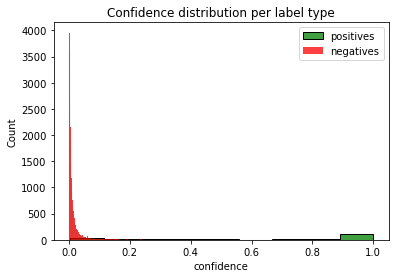

<IPython.core.display.Javascript object>

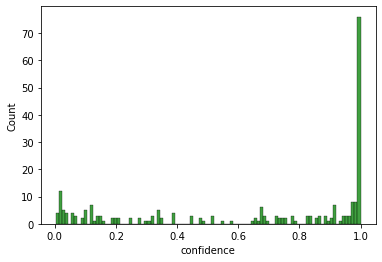

<IPython.core.display.Javascript object>

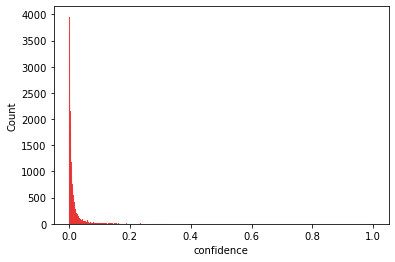

In [120]:
sns.histplot(test_df[test_df.label].confidence, color='g')
sns.histplot(test_df[~test_df.label].confidence, color='r')
plt.legend(['positives', 'negatives'])
plt.title('Confidence distribution per label type')
plt.show()

sns.histplot(test_df[test_df.label].confidence, color='g', bins=100)
plt.show()

sns.histplot(test_df[~test_df.label].confidence, color='r')
plt.show()


### Save bad candidates classification results

In [ ]:
bad_res_FP = test_df[~test_df.labels].sort_values(by=['confidence'], ascending=False).drop(columns=features_sets['fos+gabor+wavelet+haar'])
bad_res_FN = test_df[test_df.labels].sort_values(by=['confidence'], ascending=True).drop(columns=features_sets['fos+gabor+wavelet+haar'])

bad_res_FN_normals = bad_res_FN[bad_res_FN.img_id.isin(db.get_normal_imgs_ids())]
bad_res_FP_normals = bad_res_FP[bad_res_FP.img_id.isin(db.get_normal_imgs_ids())]


for _, bad_res in tqdm(bad_res_FP_normals.head(100).iterrows(), total=100):
    img_id = bad_res['img_id']
    test_img_id = db.df[db.df.img_id == img_id].index.values[0] #((2767, 2781), (1029, 1043))	
    test_img = db[test_img_id]['img']
    test_mask = db[test_img_id]['lesion_mask']
    original_test_mask = cv2.imread(str(db.full_mask_path/f'{img_id}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
    (ppx1, ppx2), (ppy1, ppy2)= bad_res['patch_coordinates']


    fig, axs = plt.subplots(4,3, figsize=(20, 8))

    for didx, delta in enumerate([0, 10, 50, 100]):
        axs[didx, 0].imshow(test_img[ppx1-delta:ppx2+delta,  ppy1-delta:ppy2+delta], cmap='gray')
        axs[didx, 0].axis('off')
        axs[didx, 0].set_title(f'Original zoom=-{delta}')

        axs[didx, 1].imshow(test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta], cmap='gray', vmin=0)
        axs[didx, 1].axis('off')
        axs[didx, 1].set_title(f'INBreast DB mask zoom=-{delta}')
        if original_test_mask is not None:
            axs[didx, 2].imshow(original_test_mask[ppx1-delta:ppx2+delta, ppy1-delta:ppy2+delta]>0, cmap='gray', vmin=0)
            axs[didx, 2].axis('off')
            axs[didx, 2].set_title(f'Original DB mask zoom=-{delta}')
    plt.savefig(f'bad_results_FP_normals/conf={bad_res["confidence"]}_{img_id}_{_}.jpg', bbox_inches="tight", dpi=600, pad_inches=0, transparent=False)
    # plt.close(fig)